In [70]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

In [71]:
data=pd.read_csv('processed_dataset.csv')

data

,city,population,total_cases,carried_over_from,opened_inside_year,finished,carried_over_to,time_since_event,population_density
0,İstanbul,15099946.0,2378387,1536743,841644,836525,1541862,3,2765.051456
1,Tekirdağ,1105759.0,127163,59444,67719,62603,64560,3,178.636349
2,Edirne,406215.0,50363,24888,25475,27064,23299,3,66.104963
3,Kırklareli,363245.0,31716,12732,18984,18939,12777,3,56.238582
4,Balıkesir,1238619.0,139589,66047,73542,74267,65322,3,84.935816
...,...,...,...,...,...,...,...,...,...
1048,Diyarbakır,1514793.0,89211,47222,41989,38964,50247,15,100.310774
1049,Mardin,736455.0,24841,7067,17774,15843,8998,15,83.878702
1050,Batman,497841.0,22390,8826,13564,13984,8406,15,111.199687
1051,Şırnak,430006.0,13615,3692,9923,9707,3908,15,60.752472


In [72]:
import random
random.seed(42)

# Preprocessing

In [73]:
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X.squeeze())
        return self

    def transform(self, X, y=None):
        return self.encoder.transform(X.squeeze()).reshape(-1, 1)


In [74]:
# İlk pipeline: city sütununu etiketlemek
label_encoding_pipeline = Pipeline(steps=[
    ('label_enc', LabelEncoderTransformer())
])

# Tüm sütunları içeren ColumnTransformer: city sütununu encode edip diğer sütunları eklemek
# Doğru sıralama ve indekslerle güncellenmiş ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('label_enc', label_encoding_pipeline, ['city']),
        ('pass', 'passthrough', ['population', 'carried_over_from', 'total_cases',
                                 'opened_inside_year', 'carried_over_to', 'finished',
                                 'time_since_event', 'population_density'])
    ]
)



In [75]:
# preprocessor'ı veri setine uygulama ve sonucu al
transformed_data = preprocessor.fit_transform(data)

# Dönüştürülmüş veriyi DataFrame olarak geri döndürme
transformed_df = pd.DataFrame(transformed_data, columns=['city_label_encoded', 'population',
                                                         'carried_over_from', 'total_cases',
                                                         'opened_inside_year', 'carried_over_to',
                                                         'finished', 'time_since_event',
                                                         'population_density'])

transformed_df


,city_label_encoded,population,carried_over_from,total_cases,opened_inside_year,carried_over_to,finished,time_since_event,population_density
0,77.0,15099946.0,1536743.0,2378387.0,841644.0,1541862.0,836525.0,3.0,2765.051456
1,65.0,1105759.0,59444.0,127163.0,67719.0,64560.0,62603.0,3.0,178.636349
2,24.0,406215.0,24888.0,50363.0,25475.0,23299.0,27064.0,3.0,66.104963
3,46.0,363245.0,12732.0,31716.0,18984.0,12777.0,18939.0,3.0,56.238582
4,11.0,1238619.0,66047.0,139589.0,73542.0,65322.0,74267.0,3.0,84.935816
...,...,...,...,...,...,...,...,...,...
1048,22.0,1514793.0,47222.0,89211.0,41989.0,50247.0,38964.0,15.0,100.310774
1049,51.0,736455.0,7067.0,24841.0,17774.0,8998.0,15843.0,15.0,83.878702
1050,13.0,497841.0,8826.0,22390.0,13564.0,8406.0,13984.0,15.0,111.199687
1051,80.0,430006.0,3692.0,13615.0,9923.0,3908.0,9707.0,15.0,60.752472


In [76]:
from sklearn.compose import make_column_selector as selector

# Sadece belirli sütunları ölçeklendirme yapacak ColumnTransformer
scaler_transformer = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), ['city_label_encoded', 'population', 'time_since_event', 'population_density'])
    ],
    remainder='passthrough'
)

In [77]:
# Pipeline oluşturma
pipeline = Pipeline(steps=[
    ('scaler', scaler_transformer)
])

In [78]:
# Pipeline'ı veri setine uygulama
processed_data = pipeline.fit_transform(transformed_df)

# Dönüştürülmüş veriyi DataFrame olarak geri döndürme
processed_df = pd.DataFrame(processed_data, columns=['city_label_encoded', 'population',
                                                        'time_since_event','population_density',
                                                         'carried_over_from',  'total_cases',
                                                       'opened_inside_year','carried_over_to' ,
                                                           'finished'
                                                       ])

processed_df

,city_label_encoded,population,time_since_event,population_density,carried_over_from,total_cases,opened_inside_year,carried_over_to,finished
0,0.925,19.785894,-1.0,39.361131,1536743.0,2378387.0,841644.0,1541862.0,836525.0
1,0.625,0.792878,-1.0,1.726081,59444.0,127163.0,67719.0,64560.0,62603.0
2,-0.400,-0.156548,-1.0,0.088631,24888.0,50363.0,25475.0,23299.0,27064.0
3,0.150,-0.214868,-1.0,-0.054935,12732.0,31716.0,18984.0,12777.0,18939.0
4,-0.725,0.973197,-1.0,0.362640,66047.0,139589.0,73542.0,65322.0,74267.0
...,...,...,...,...,...,...,...,...,...
1048,-0.450,1.348022,1.0,0.586362,47222.0,89211.0,41989.0,50247.0,38964.0
1049,0.275,0.291656,1.0,0.347258,7067.0,24841.0,17774.0,8998.0,15843.0
1050,-0.675,-0.032193,1.0,0.744807,8826.0,22390.0,13564.0,8406.0,13984.0
1051,1.000,-0.124259,1.0,0.010747,3692.0,13615.0,9923.0,3908.0,9707.0


# Accuracy Calculation Function

In [79]:
def calculate_accuracy(y_pred, y_true):
  # Print predicted and real y-values for the first 10 rows
  for i in range(10):
      print("Predicted:", y_pred[i], "\tReal:", y_true.iloc[i])

  # Calculate absolute percentage error for each prediction
  absolute_percentage_errors = np.abs((y_true - y_pred) / y_true)

  # Calculate mean absolute percentage error
  mape = np.mean(absolute_percentage_errors)

  # Convert MAPE to accuracy (accuracy = 1 - MAPE)
  accuracy = 1 - mape

  # Convert accuracy to percentage
  percentage_accuracy = accuracy * 100

  print("Average Percentage Accuracy for prediction:", percentage_accuracy)

# Test Train Split

In [80]:
# Drop non-feature columns from the DataFrame for opened_inside_year prediction
X_opened_inside_year = processed_df.drop(columns=['opened_inside_year', 'carried_over_from', 'finished', 'carried_over_to', 'total_cases'])
y_opened_inside_year = processed_df['opened_inside_year']

# Drop non-feature columns from the DataFrame for finished prediction
X_finished = processed_df.drop(columns=['carried_over_from', 'finished', 'carried_over_to', 'total_cases'])
y_finished = processed_df['finished']


# Split data into training and testing sets for both predictions
X_train_opened, X_test_opened, y_train_opened, y_test_opened = X_opened_inside_year.iloc[81:], X_opened_inside_year.iloc[:81], y_opened_inside_year.iloc[81:], y_opened_inside_year.iloc[:81]
X_train_finished, X_test_finished, y_train_finished, y_test_finished = X_finished.iloc[81:], X_finished.iloc[:81], y_finished.iloc[81:], y_finished.iloc[:81]

# DecisionTreeRegressor

### DecisionTreeRegressor parametre tuning for predicting opened_inside_year

In [81]:
# Define the pipeline for opened_inside_year prediction
model_for_opened_inside_year = Pipeline(steps=[
    ('regressor', DecisionTreeRegressor())
])

# Define grid search parameters for opened_inside_year prediction
param_grid_opened = {
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Perform grid search for opened_inside_year prediction
grid_search_opened = GridSearchCV(model_for_opened_inside_year, param_grid_opened, cv=5, verbose=2)
grid_search_opened.fit(X_train_opened, y_train_opened)
best_model_opened_inside_year = grid_search_opened.best_estimator_

# Predict on test set for opened_inside_year prediction
y_pred_opened = best_model_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened, y_test_opened)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5; total time=   0.0s
[CV] END r

[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=2, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=2, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=2, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=2, re

In [82]:
print(grid_search_opened.best_params_)

{'regressor__max_depth': 20, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}


### DecisionTreeRegressor parametre tuning for predicting finished

In [83]:
# Define the pipeline for finished prediction
model_for_finished = Pipeline(steps=[
    ('regressor', DecisionTreeRegressor())
])

# Define grid search parameters for finished prediction
param_grid_finished = {
    'regressor__max_depth': [10, 20, 30, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Perform grid search for finished prediction
grid_search_finished = GridSearchCV(model_for_finished, param_grid_finished, cv=5, verbose=2)
grid_search_finished.fit(X_train_finished, y_train_finished)
best_model_finished = grid_search_finished.best_estimator_

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished)

calculate_accuracy(y_pred_finished, y_test_finished)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_leaf=1, regressor__min_samples_split=5; total time=   0.0s
[CV] END r

[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=20, regressor__min_samples_leaf=4, regressor__min_samples_split=10; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=30, regressor__min_samples_leaf=1, reg

[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=2; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=5; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=5; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__min_samples_leaf=4, regressor__min_samples_split=5; total time=   0.0s
[CV] END regressor__max_depth=None, regressor__min_sampl

In [84]:
print(grid_search_finished.best_params_)

{'regressor__max_depth': 30, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 5}


### Testing best models one after another


In [85]:
X_test_finished_with_predicted_opened_inside_year = X_test_finished.copy()
X_test_finished_with_predicted_opened_inside_year['opened_inside_year'] = y_pred_opened

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished_with_predicted_opened_inside_year)

calculate_accuracy(y_pred_finished, y_test_finished)

Predicted: 732536.6666666666 	Real: 836525.0
Predicted: 36453.666666666664 	Real: 62603.0
Predicted: 28716.0 	Real: 27064.0
Predicted: 22038.75 	Real: 18939.0
Predicted: 61208.0 	Real: 74267.0
Predicted: 28755.2 	Real: 33954.0
Predicted: 246526.33333333334 	Real: 289353.0
Predicted: 73249.0 	Real: 85850.0
Predicted: 55817.0 	Real: 61448.0
Predicted: 71613.8 	Real: 78778.0
Average Percentage Accuracy for prediction: 86.61044042876311


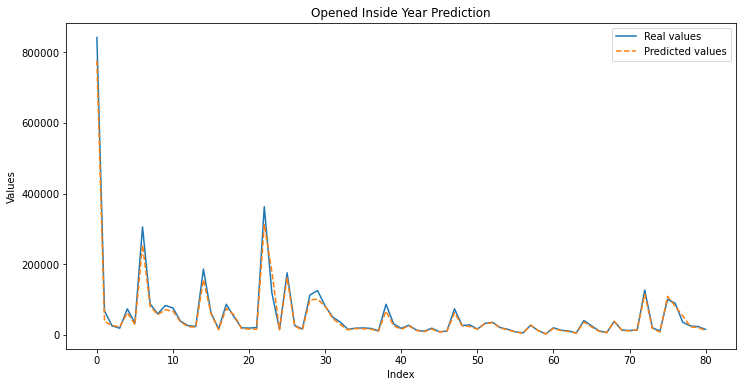

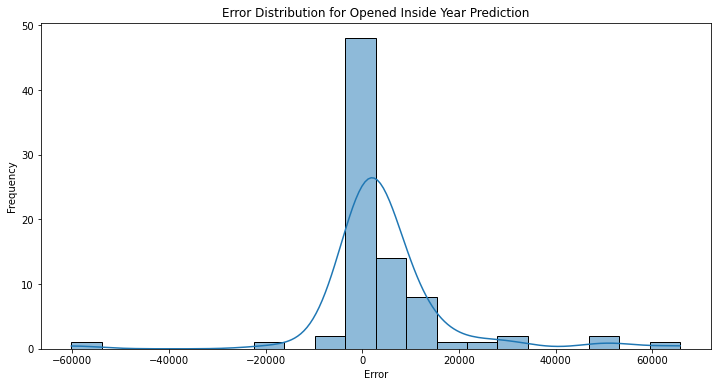

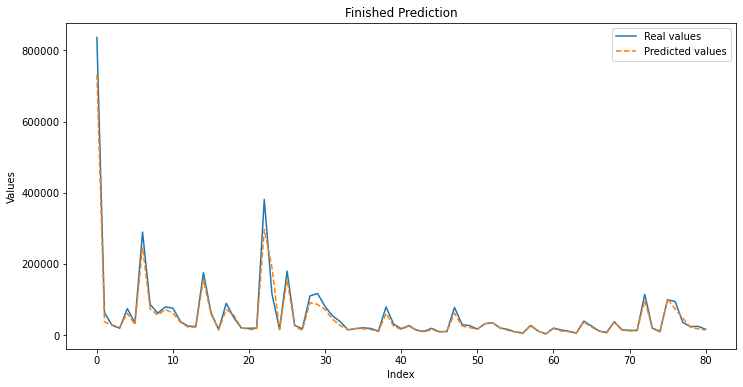

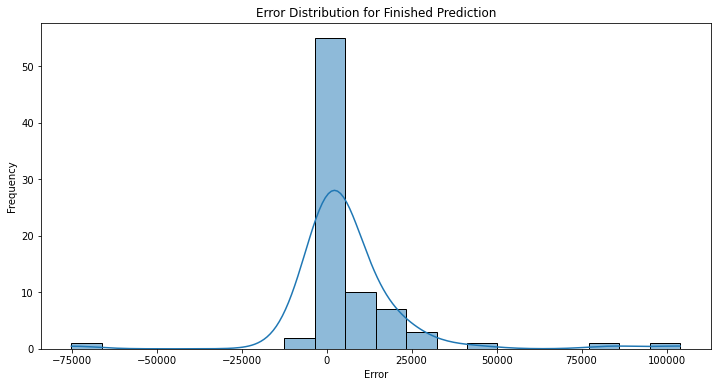

In [86]:
# Gerçek ve tahmin edilen değerlerin çizimi
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Real values')
    plt.plot(y_pred, label='Predicted values', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

# Hata dağılımının çizimi
def plot_error_distribution(y_true, y_pred, title):
    errors = y_true - y_pred
    plt.figure(figsize=(12, 6))
    sns.histplot(errors, kde=True, bins=20)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_opened, y_pred_opened, 'Opened Inside Year Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_opened, y_pred_opened, 'Error Distribution for Opened Inside Year Prediction')

# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished, 'Finished Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_finished, 'Error Distribution for Finished Prediction')


# RandomForestRegressor



#### RandomForestRegressor parametre tuning for predicting opened_inside_year

In [87]:
# Define the pipeline for opened_inside_year prediction
model_for_opened_inside_year = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define grid search parameters
param_grid_opened = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}

# Perform grid search for opened_inside_year prediction
grid_search_opened = GridSearchCV(model_for_opened_inside_year, param_grid_opened, cv=5, verbose=2)
grid_search_opened.fit(X_train_opened, y_train_opened)
best_model_opened_inside_year = grid_search_opened.best_estimator_

# Predict on test set for opened_inside_year prediction
y_pred_opened = best_model_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened, y_test_opened)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.2s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END r

[CV] END regressor__max_depth=10, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   0.4s
[CV] END regressor__max_depth=10, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   0.4s
[CV] END regressor__max_depth=10, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   0.4s
[CV] END regressor__max_depth=10, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   0.3s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_esti

[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=30, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=30, regressor__min_samples_split=5, regressor__n_estimator

In [88]:
print(grid_search_opened.best_params_)

{'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}


#### RandomForestRegressor parametre tuning for predicting finished

In [89]:
# Define the pipeline for finished prediction
model_for_finished = Pipeline(steps=[
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define grid search parameters
param_grid_finished = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10]
}


# Perform grid search for finished prediction
grid_search_finished = GridSearchCV(model_for_finished, param_grid_finished, cv=5, verbose=2)
grid_search_finished.fit(X_train_finished, y_train_finished)
best_model_finished = grid_search_finished.best_estimator_

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished)

calculate_accuracy(y_pred_finished, y_test_finished)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.4s
[CV] END r

[CV] END regressor__max_depth=10, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   0.4s
[CV] END regressor__max_depth=10, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=10, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=10, regressor__min_samples_split=5, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=10, regressor__min_samples_split=10, regressor__n_esti

[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=200; total time=   0.3s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.6s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.6s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.6s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.5s
[CV] END regressor__max_depth=30, regressor__min_samples_split=2, regressor__n_estimators=300; total time=   0.6s
[CV] END regressor__max_depth=30, regressor__min_samples_split=5, regressor__n_estimators=100; total time=   0.1s
[CV] END regressor__max_depth=30, regressor__min_samples_split=5, regressor__n_estimator

In [90]:
print(grid_search_finished.best_params_)

{'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}


#### Testing best models one after another


In [91]:
X_test_finished_with_predicted_opened_inside_year = X_test_finished.copy()
X_test_finished_with_predicted_opened_inside_year['opened_inside_year'] = y_pred_opened

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished_with_predicted_opened_inside_year)

calculate_accuracy(y_pred_finished, y_test_finished)

Predicted: 674204.8727528859 	Real: 836525.0
Predicted: 54284.65007111073 	Real: 62603.0
Predicted: 25479.423668155876 	Real: 27064.0
Predicted: 18263.42857315618 	Real: 18939.0
Predicted: 62069.70199447468 	Real: 74267.0
Predicted: 26858.138972338376 	Real: 33954.0
Predicted: 243338.38843518522 	Real: 289353.0
Predicted: 72126.42523389358 	Real: 85850.0
Predicted: 56785.02937744266 	Real: 61448.0
Predicted: 61450.80009988098 	Real: 78778.0
Average Percentage Accuracy for prediction: 88.75077552589607


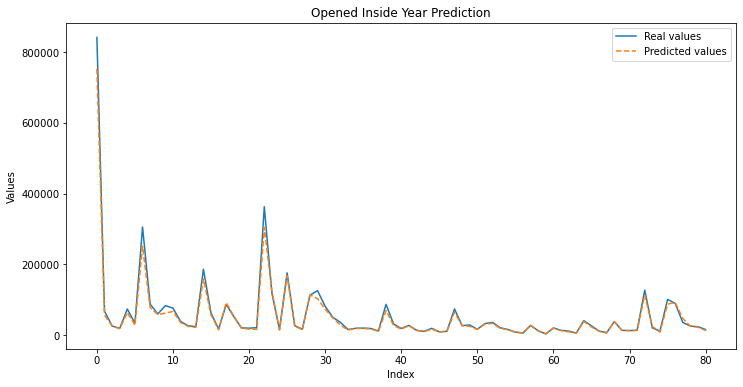

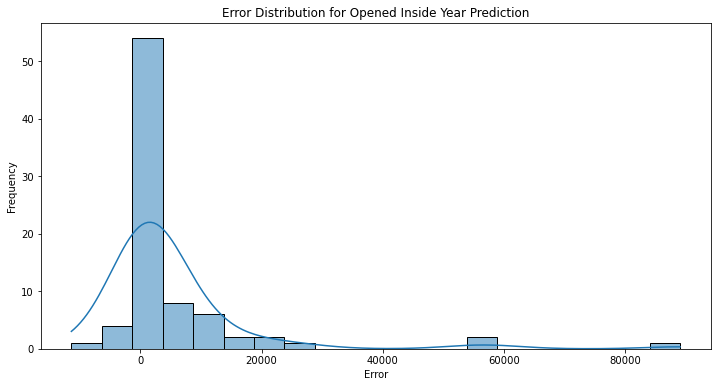

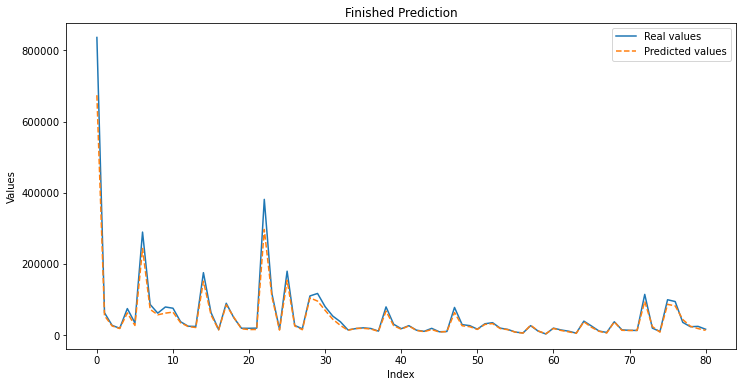

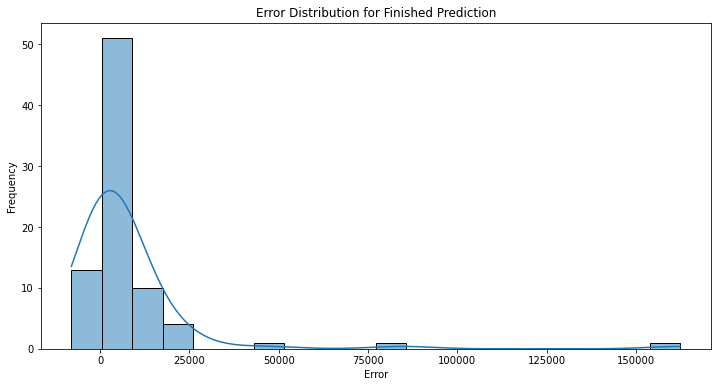

In [92]:
# Gerçek ve tahmin edilen değerlerin çizimi
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Real values')
    plt.plot(y_pred, label='Predicted values', linestyle='--')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

# Hata dağılımının çizimi
def plot_error_distribution(y_true, y_pred, title):
    errors = y_true - y_pred
    plt.figure(figsize=(12, 6))
    sns.histplot(errors, kde=True, bins=20)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_opened, y_pred_opened, 'Opened Inside Year Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_opened, y_pred_opened, 'Error Distribution for Opened Inside Year Prediction')

# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished, 'Finished Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_finished, y_pred_finished, 'Error Distribution for Finished Prediction')



# GradientBoostingRegressor



#### GradientBoostingRegressor parametre tuning for predicting opened_inside_year

In [93]:
# Define the pipeline for opened_inside_year prediction
model_for_opened_inside_year = Pipeline(steps=[
    ('regressor', GradientBoostingRegressor())
])

# Define grid search parameters
param_grid_opened = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}


# Perform grid search for opened_inside_year prediction
grid_search_opened = GridSearchCV(model_for_opened_inside_year, param_grid_opened, cv=5, verbose=2)
grid_search_opened.fit(X_train_opened, y_train_opened)
best_model_opened_inside_year = grid_search_opened.best_estimator_

# Predict on test set for opened_inside_year prediction
y_pred_opened = best_model_opened_inside_year.predict(X_test_opened)

calculate_accuracy(y_pred_opened, y_test_opened)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.0s
[CV] END regressor__learning_rate=0.05, re

[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__n_estimators=300; total time=   0.1s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__n_estimators=300; total time=   0.1s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200; total time=   0.1s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200; total time=   0.1s
[

In [94]:
print(grid_search_opened.best_params_)

{'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__n_estimators': 200}


#### GradientBoostingRegressor parametre tuning for predicting finished

In [95]:
# Define the pipeline for finished prediction
model_for_finished = Pipeline(steps=[
    ('regressor', GradientBoostingRegressor(random_state=42))
])

# Define grid search parameters
param_grid_finished = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 4, 5]
}


# Perform grid search for finished prediction
grid_search_finished = GridSearchCV(model_for_finished, param_grid_finished, cv=5, verbose=2)
grid_search_finished.fit(X_train_finished, y_train_finished)
best_model_finished = grid_search_finished.best_estimator_

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished)

calculate_accuracy(y_pred_finished, y_test_finished)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=200; total time=   0.0s
[CV] END regressor__learning_rate=0.05, re

[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__n_estimators=300; total time=   0.2s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=4, regressor__n_estimators=300; total time=   0.2s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=100; total time=   0.0s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200; total time=   0.1s
[CV] END regressor__learning_rate=0.1, regressor__max_depth=5, regressor__n_estimators=200; total time=   0.1s
[

In [96]:
print(grid_search_finished.best_params_)

{'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 300}


#### Testing best models one after another


In [97]:
X_test_finished_with_predicted_opened_inside_year = X_test_finished.copy()
X_test_finished_with_predicted_opened_inside_year['opened_inside_year'] = y_pred_opened

# Predict on test set for finished prediction
y_pred_finished = best_model_finished.predict(X_test_finished_with_predicted_opened_inside_year)

calculate_accuracy(y_pred_finished, y_test_finished)

Predicted: 661290.2377899813 	Real: 836525.0
Predicted: 54809.24182562427 	Real: 62603.0
Predicted: 22424.04653007626 	Real: 27064.0
Predicted: 16522.317203820956 	Real: 18939.0
Predicted: 60598.841856562845 	Real: 74267.0
Predicted: 28841.28495479523 	Real: 33954.0
Predicted: 237655.14890758274 	Real: 289353.0
Predicted: 67521.43071655523 	Real: 85850.0
Predicted: 54575.34847676521 	Real: 61448.0
Predicted: 62856.436774399604 	Real: 78778.0
Average Percentage Accuracy for prediction: 87.75864147808359


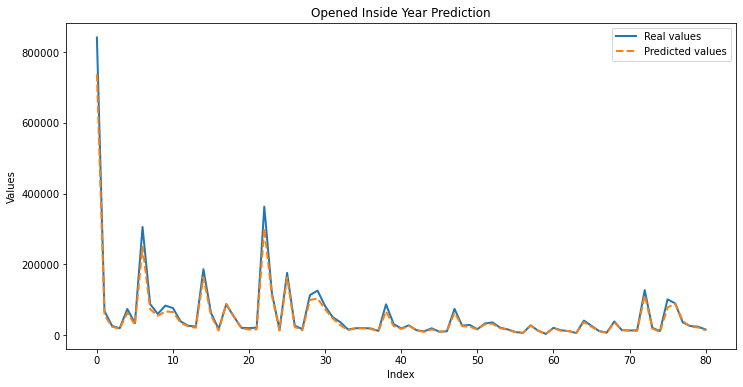

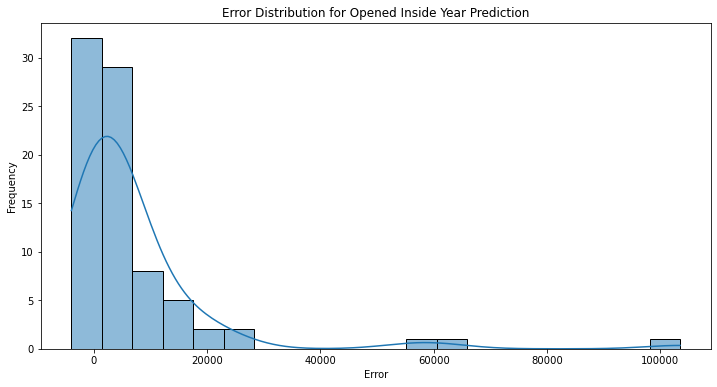

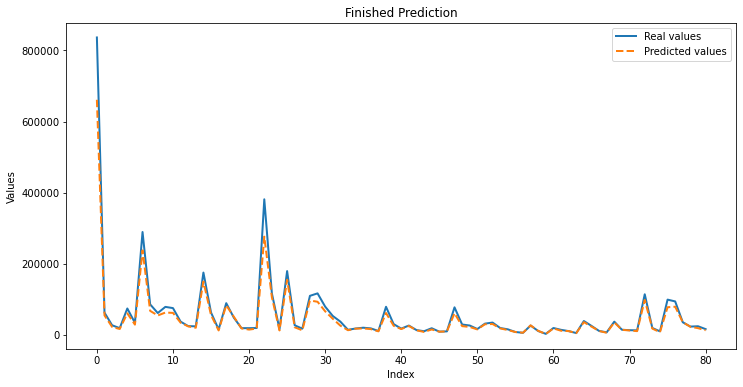

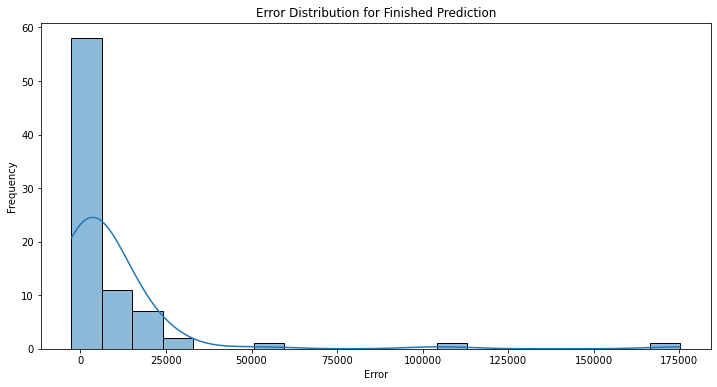

In [99]:
# Gerçek ve tahmin edilen değerlerin çizimi
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_true)), y_true, label='Real values', linewidth=2)
    plt.plot(range(len(y_true)), y_pred, label='Predicted values', linestyle='--', linewidth=2)
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title(title)
    plt.legend()
    plt.show()

# Hata dağılımının çizimi
def plot_error_distribution(y_true, y_pred, title):
    errors = y_true - y_pred
    plt.figure(figsize=(12, 6))
    sns.histplot(errors, kde=True, bins=20)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_opened, y_pred_opened, 'Opened Inside Year Prediction')

# Hata dağılımının çizimi
plot_error_distribution(y_test_opened, y_pred_opened, 'Error Distribution for Opened Inside Year Prediction')

# Gerçek ve tahmin edilen değerlerin çizimi
plot_predictions(y_test_finished, y_pred_finished, 'Finished Prediction')

# Hata dağılımının çizimi (Bitmiş Tahmini)
plot_error_distribution(y_test_finished, y_pred_finished, 'Error Distribution for Finished Prediction')
